In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt

# Read image metadata

Use PIL to read image metadata.
Some experimentation is done to save images as .tiff files with the same metadata as the source images

In [7]:
from PIL import Image
from PIL.TiffTags import TAGS

img = Image.open('data/0703.tiff')
# out = Image.fromarray(cv2.imread('data/0703.tiff', -1))
# # out.tag_v2 = img.tag_v2 # Does not copy all metadata for some reason
# # print(img.tag_v2, out.tag_v2)
# out.save('sample.tiff', tiffinfo = img.tag_v2) # Use this to copy metadata as it copies all metadata tags from source
write_tiff(img, 'sample.tiff', cv2.imread('data/0703.tiff', -1))

In [8]:
from tifffile import TiffFile

tif = TiffFile('data/0703.tiff')

for page in tif.pages:
    for tag in page.tags:
        print(tag.name, tag.value)

print()
tif = TiffFile('sample.tiff')

for page in tif.pages:
    for tag in page.tags:
        print(tag.name, tag.value)

ImageWidth 2008
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
StripOffsets (8,)
Orientation ORIENTATION.BOTLEFT
SamplesPerPixel 1
RowsPerStrip 2048
StripByteCounts (8224768,)
XResolution (4294967295, 9005797)
YResolution (4294967295, 9005797)
PlanarConfiguration PLANARCONFIG.CONTIG
ResolutionUnit RESUNIT.CENTIMETER
SampleFormat SAMPLEFORMAT.UINT

ImageWidth 2008
ImageLength 2048
BitsPerSample 16
Compression COMPRESSION.NONE
PhotometricInterpretation PHOTOMETRIC.MINISBLACK
StripOffsets (210,)
Orientation ORIENTATION.BOTLEFT
SamplesPerPixel 1
RowsPerStrip 2048
StripByteCounts (8224768,)
XResolution (4294967295, 9005797)
YResolution (4294967295, 9005797)
PlanarConfiguration PLANARCONFIG.CONTIG
ResolutionUnit RESUNIT.CENTIMETER
SampleFormat SAMPLEFORMAT.UINT


# Helper functions

Implement any commonly used functions here.

In [3]:
# Plot images as a grid
def my_plot(rows, cols, images, cmap='gray'):
    if len(images) > rows * cols:
        raise Exception('Number of images passed exceeds dimensions of grid')
    
    subfigs = []
    fig = plt.figure(figsize = (rows * 10, cols * 10))
    
    for i in range(rows):
        for j in range(cols):
            subfigs.append(fig.add_subplot(rows, cols, i * cols + j + 1))
    
    for i in range(len(images)):
        if cmap == 'gray':
            subfigs[i].imshow(images[i], cmap='gray', vmin=0, vmax=255)
        else:
            subfigs[i].imshow(images[i])

In [4]:
# Save tiff image with metadata
def write_tiff(tiff_template, dest_path, img):    
    out = Image.fromarray(img)
    out.save(dest_path, tiffinfo = tiff_template.tag_v2)

In [5]:
# Convert all datasets to videos (for better visualization)
from pathlib import Path

def get_tiff_dict(path):
    tiff_files = Path(path).rglob('*.tiff')
    tiff_dirs = {}
    for tiff_file in tiff_files:
        tiff_file = str(tiff_file)
        if tiff_file.split('/')[-1][0] == '.':
            continue
            
        tiff_dir = '/'.join(tiff_file.split('/')[: -1])
        if tiff_dir in tiff_dirs.keys():
            tiff_dirs[tiff_dir].append(tiff_file)
        else:
            tiff_dirs[tiff_dir] = [tiff_file]
    
    return tiff_dirs

def create_tiff_videos(path):
    tiff_dirs = get_tiff_dict(path)
    
    for tiff_dir in tiff_dirs.keys():
        size = ()
        
        img = cv2.imread(tiff_dirs[tiff_dir][0])
        height, width, layers = img.shape
        size = (width, height)
        save_path = 'data/' + tiff_dir.split('/')[-1]

        out = cv2.VideoWriter(save_path + '.mp4', cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
        
        for tiff_file in sorted(tiff_dirs[tiff_dir]):
            img = cv2.imread(tiff_file)
            out.write(img)
        
        out.release()

# create_tiff_videos('/media/chethan749/Honeycomb/combined/')

In [248]:
# Normalize the image to improve contrast
def normalize(img):
    return cv2.equalizeHist(img)

# Read data

Read and plot some sample images and their normalized images

In [249]:
img1 = cv2.imread('data/0703.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.imread('data/1941.tiff', cv2.IMREAD_GRAYSCALE)
img2 = cv2.resize(img2, (img1.shape[1], img1.shape[0]))

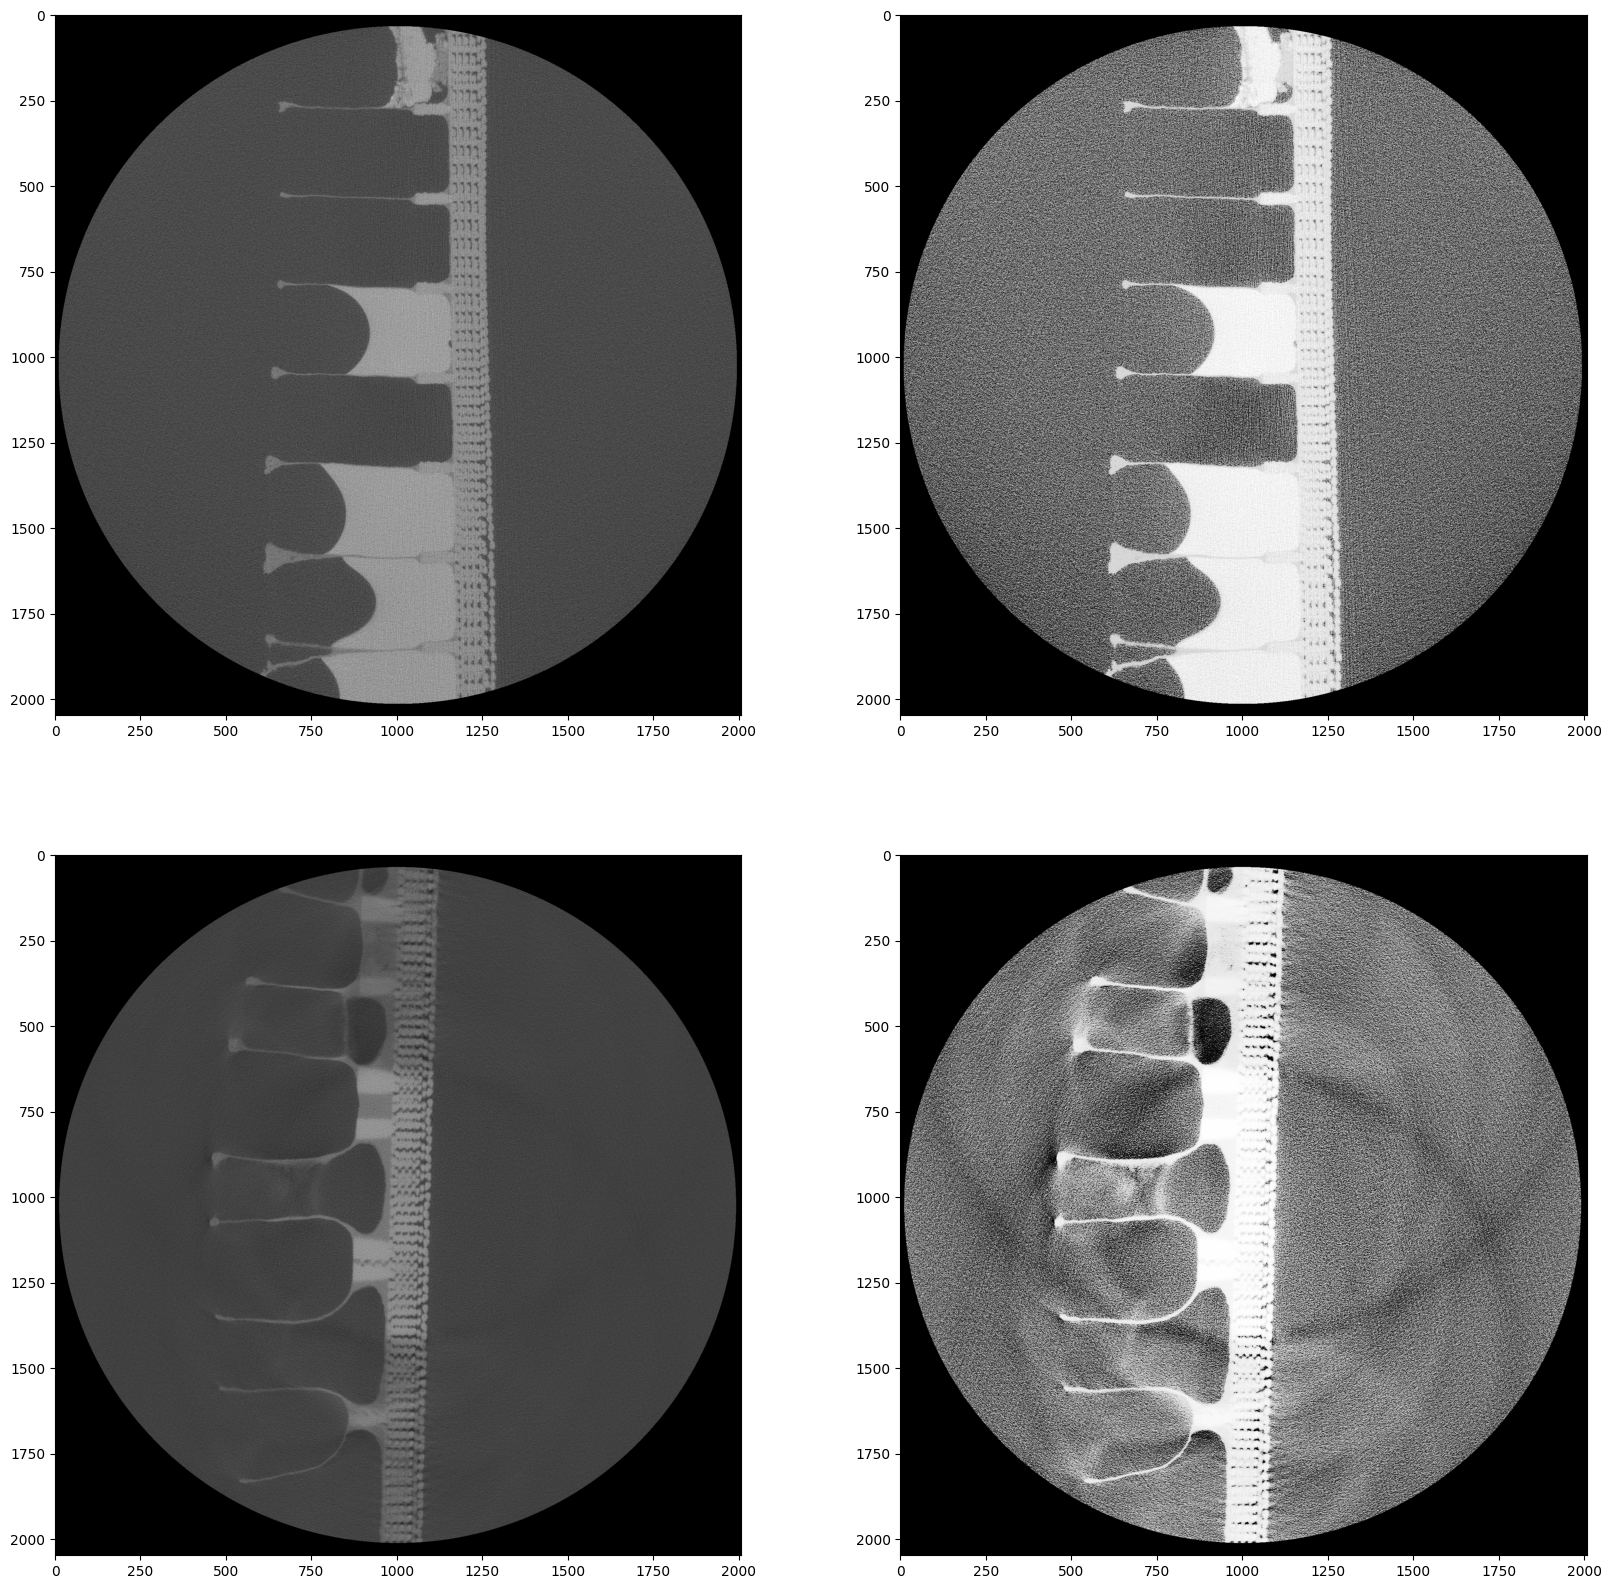

In [250]:
my_plot(2, 2, [img1, normalize(img1), img2, normalize(img2)])

# Initial analysis - Simple image processing operations

* Gaussian Blur to denoise the image

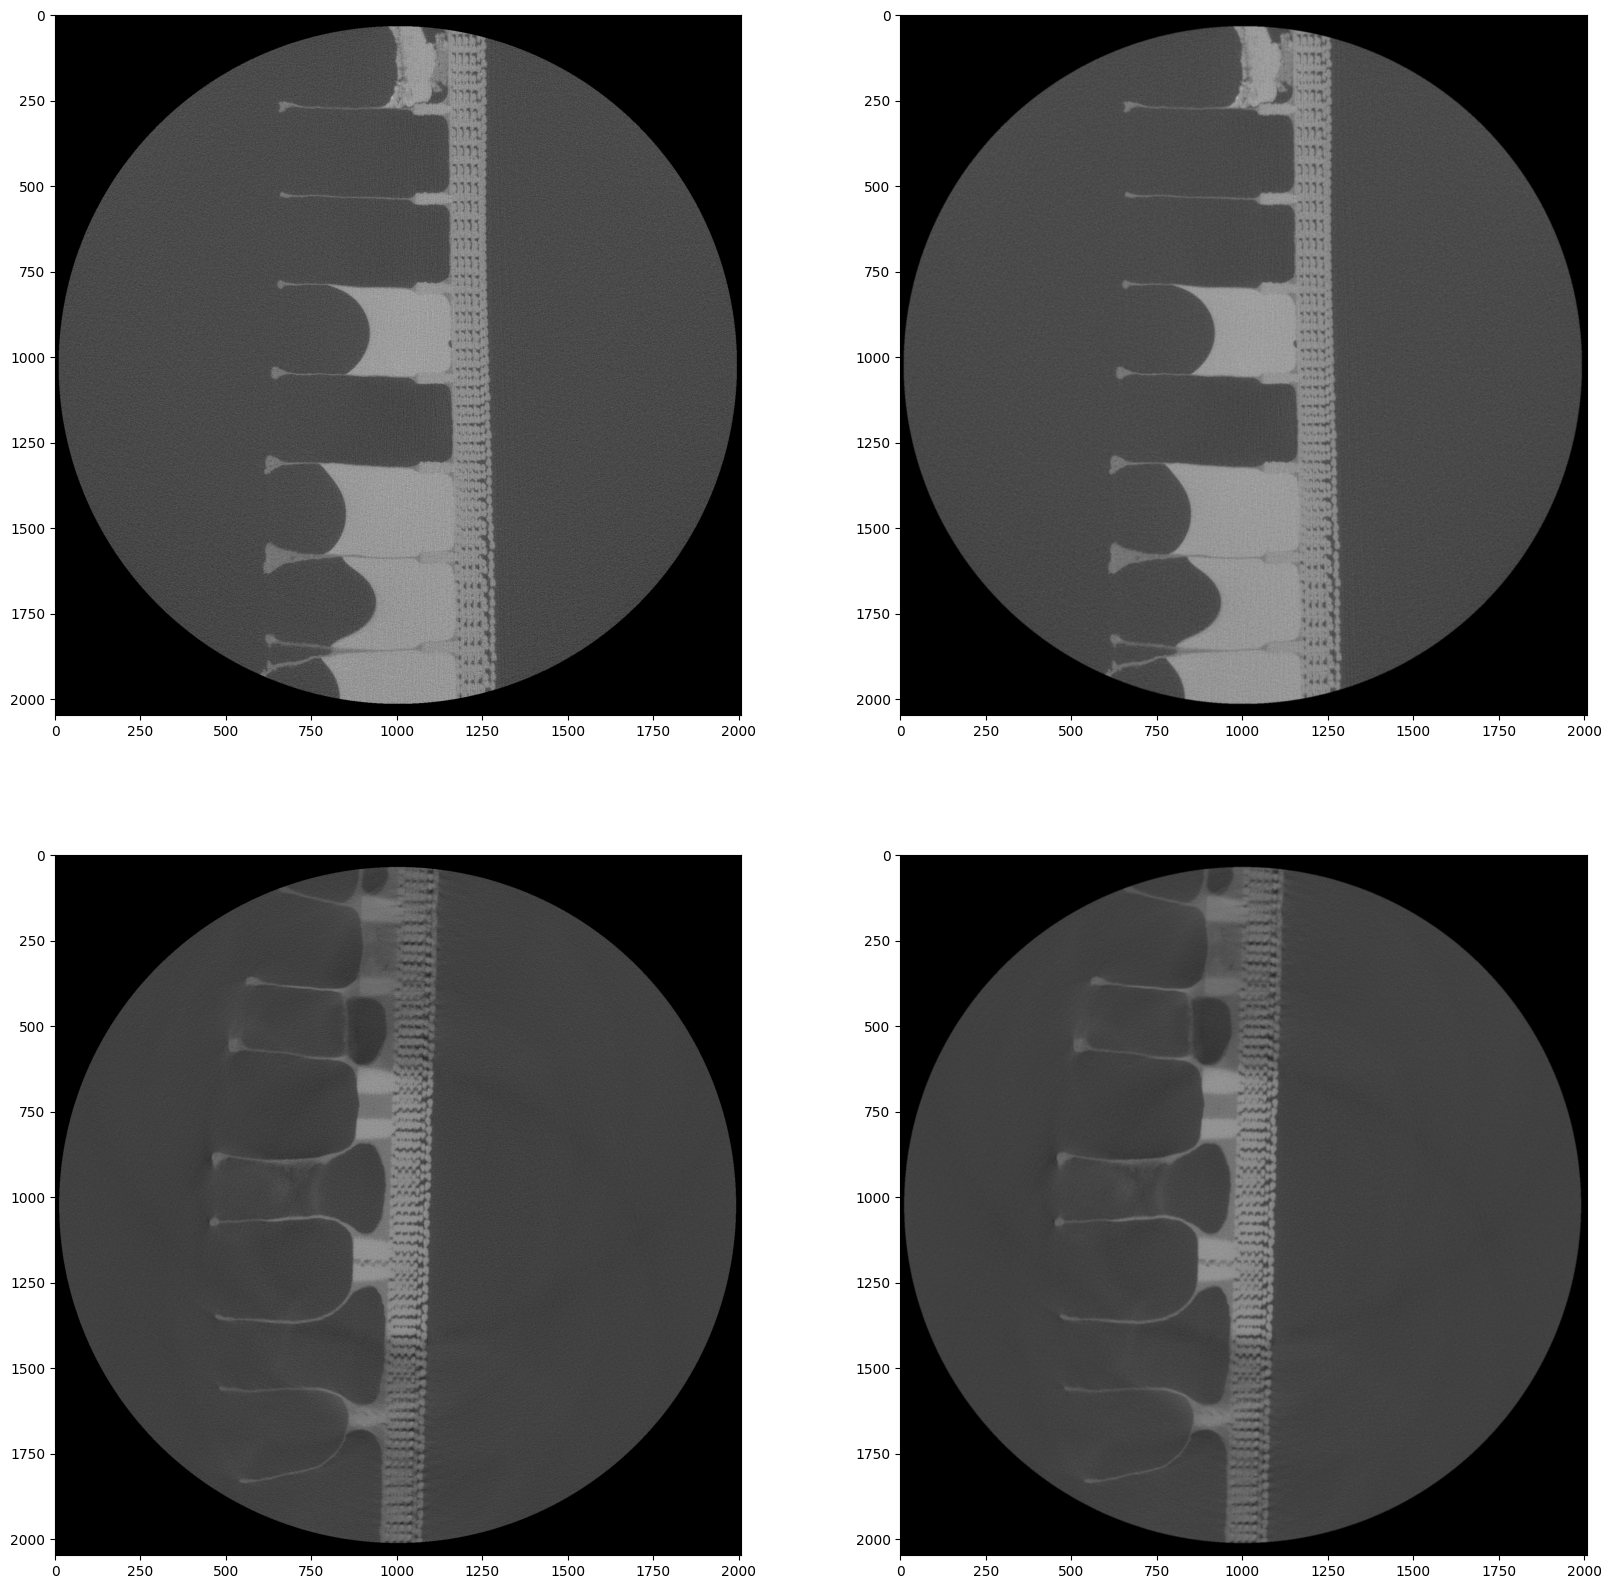

In [251]:
# Gaussian blur to remove noise
blurred_img1 = cv2.GaussianBlur(img1,(5,5),0)
blurred_img2 = cv2.GaussianBlur(img2,(5,5),0)

my_plot(2, 2, [img1, blurred_img1, img2, blurred_img2])

## Threshold and Contour

* Thresholding produces a good segmentation of the honeycomb when given the right threshold value, but finding the right threshold value is a challenge.
* The threshold value used below is hardcoded based on trial and error and this would not be an optimal value for every single frame.

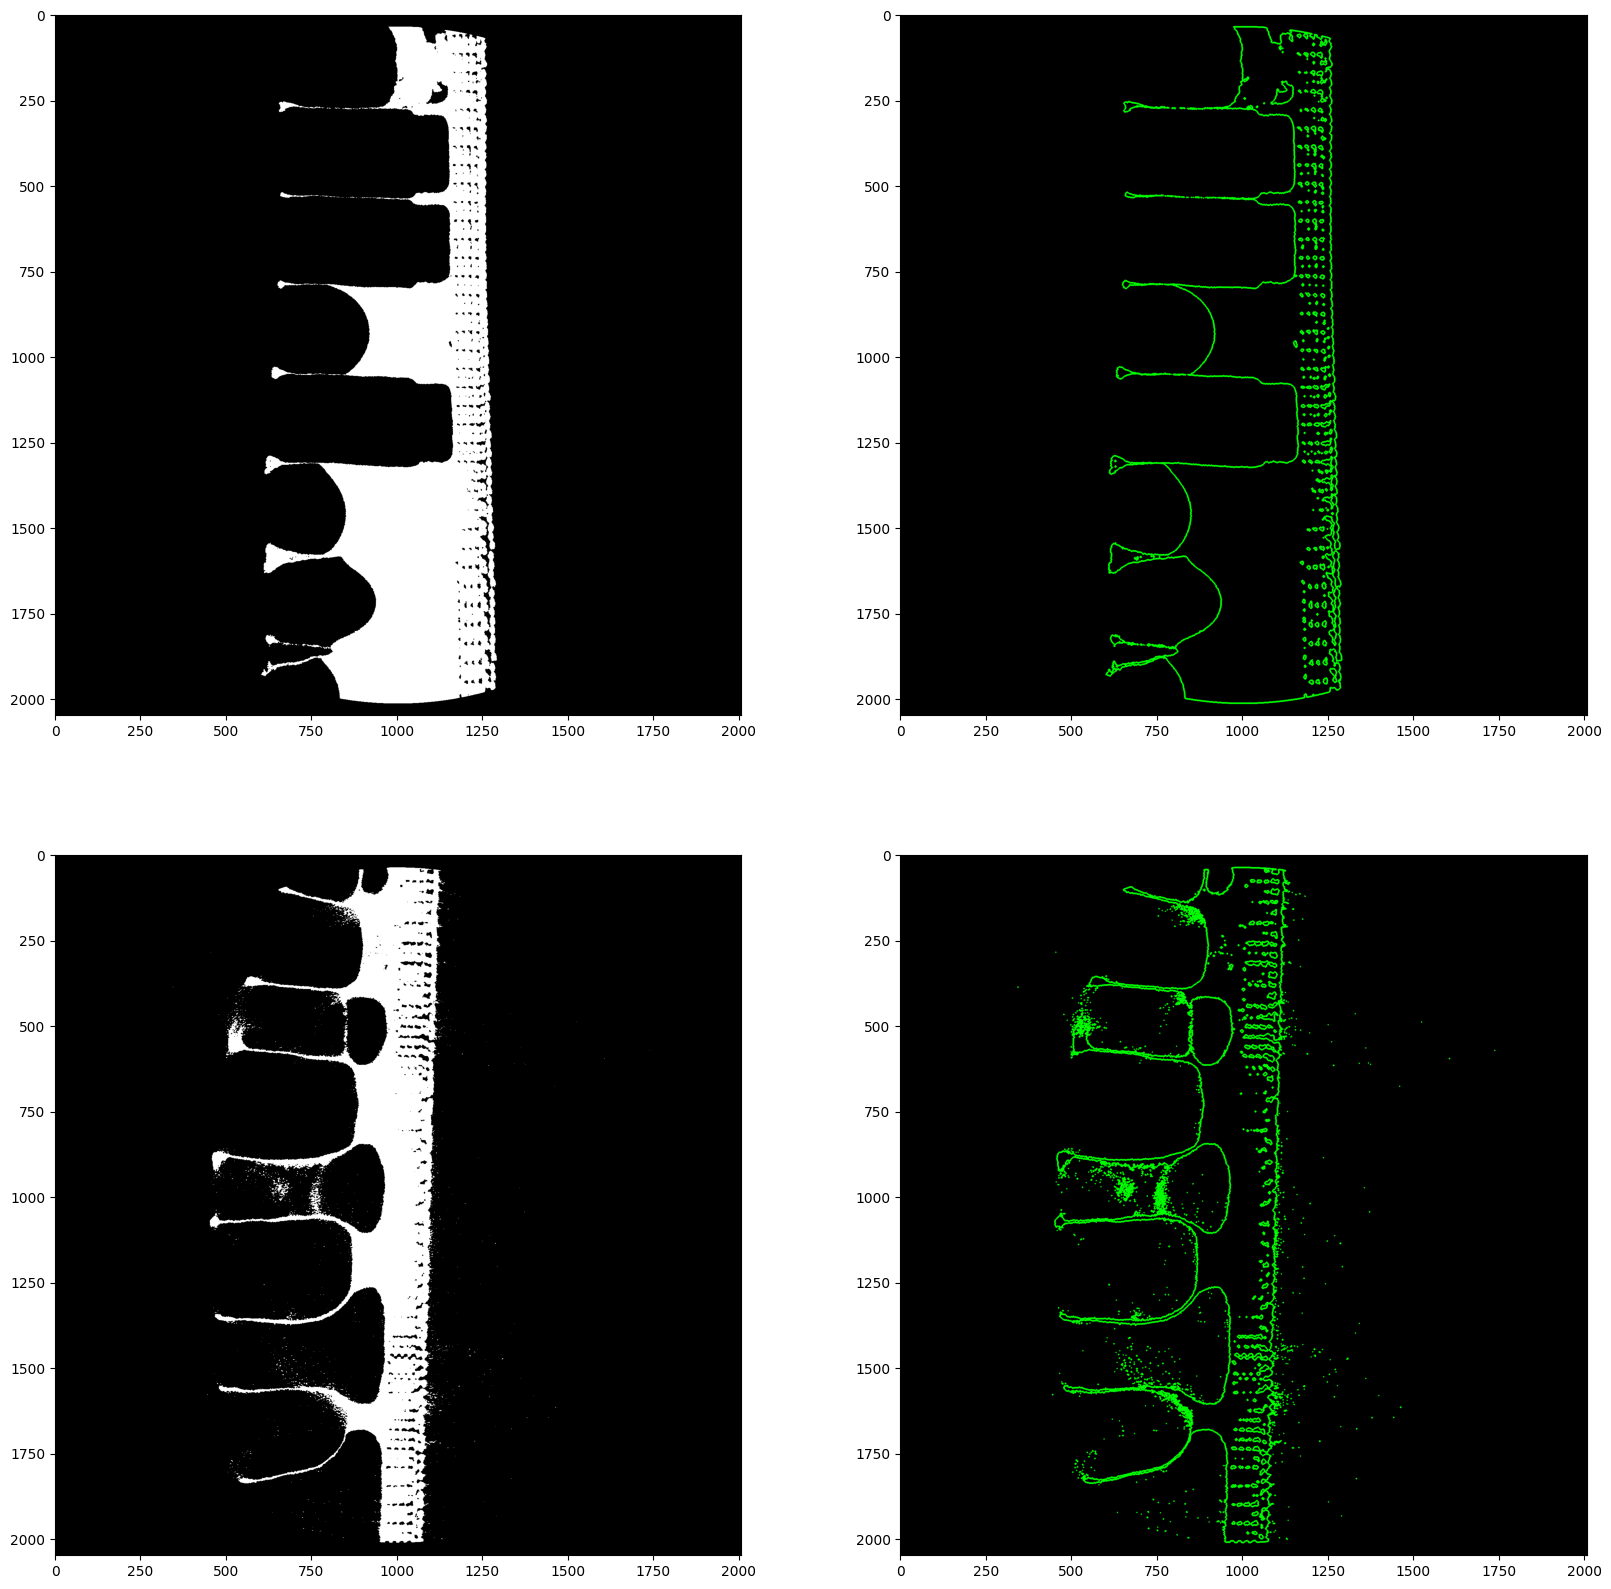

In [262]:
# Threshold and get contours. TODO: Any ways to automate finding threshold value?
def get_thresh_contours(img):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(5,5),0)
    # Threshold value of 200 is chosen based on trial and error
    ret, thresh = cv2.threshold(blurred_img, 200, 255, 0)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_thresh_contours(img1)
thresh2, contour_img2 = get_thresh_contours(img2)

my_plot(2, 2, [thresh1, contour_img1, thresh2, contour_img2])

Due to the limitations of regular thresholding, as mentioned above, adaptive thresholding is attempted instead.
* Hardcoding values is not necessary, however some parameters like the kernel size and C value must be given (Refer to OpenCV docs)
* Produces good results but the output is very noisy. Moreover, some of the foreground is lost during this process
* Some morphologival operations are necessary to clean the segmented image

array([  0, 255], dtype=uint8)

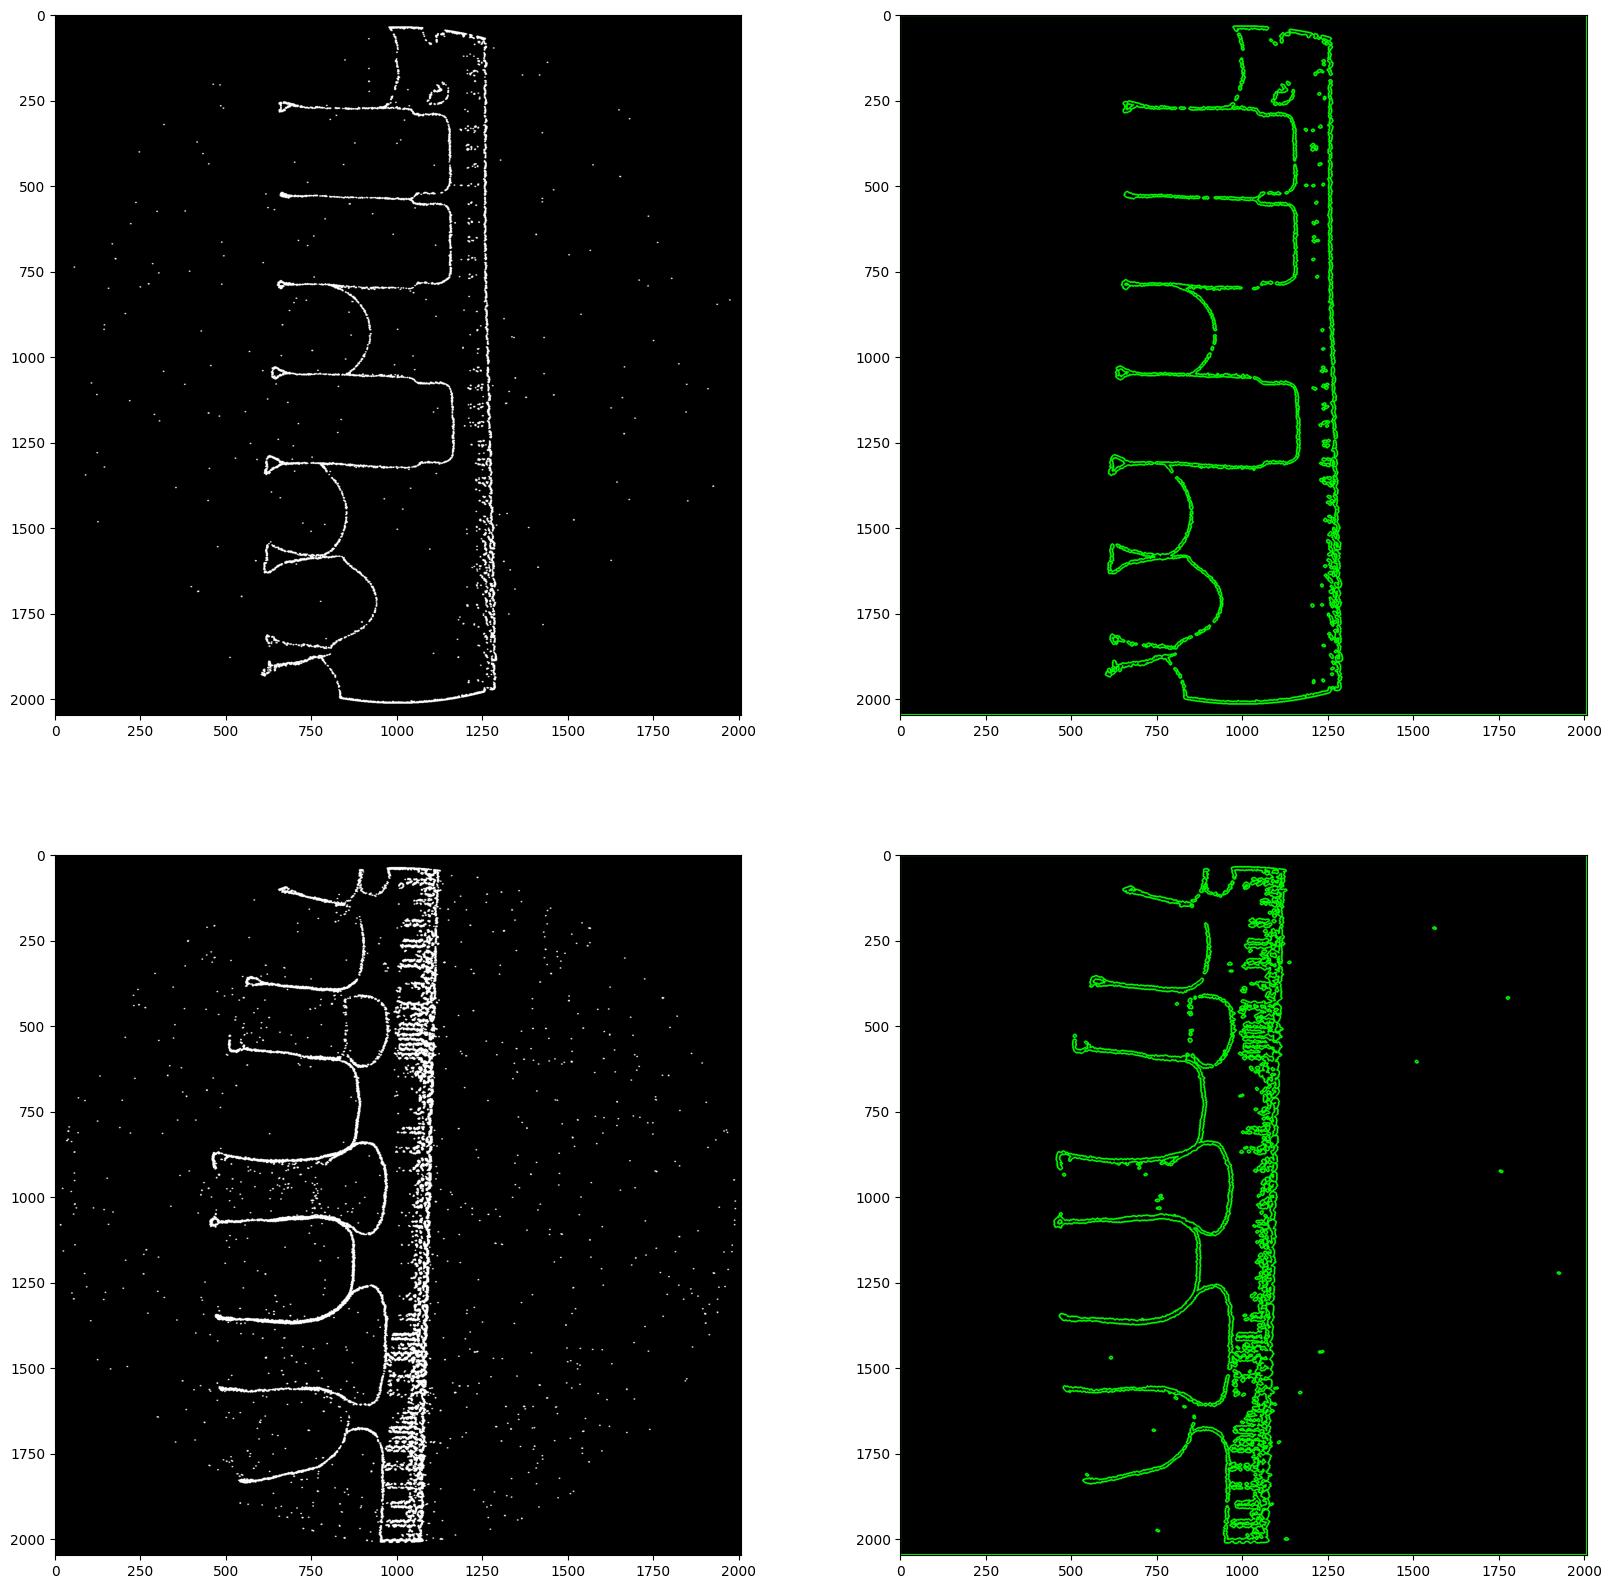

In [255]:
def get_adaptive_thresh_contours(img):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(7,7),0)
    thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 25, -2)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    # Find contours and only keep contours that are relatively big (i.e., not noise)
    contours, hierarchy = cv2.findContours(255 - thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    new_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > 42:
            new_contours.append(contour)
    contour_img = np.zeros(cv2.cvtColor(img, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(contour_img, new_contours, -1, (0,255,0), 3)
    
    return thresh, contour_img

thresh1, contour_img1 = get_adaptive_thresh_contours(img1)
thresh2, contour_img2 = get_adaptive_thresh_contours(img2)

my_plot(2, 2, [thresh1, contour_img1, thresh2, contour_img2])
np.unique(thresh1)

# Edge detection

An automatic Canny edge detector is used. It takes a sigma value as input which is a measure of the range of lower and upper bound that cv2.Canny takes for edge segmentation.
* It is difficult to fine-tune a sigma value that works for all possible scenarios
* Edges are hit-or-miss and not consistent

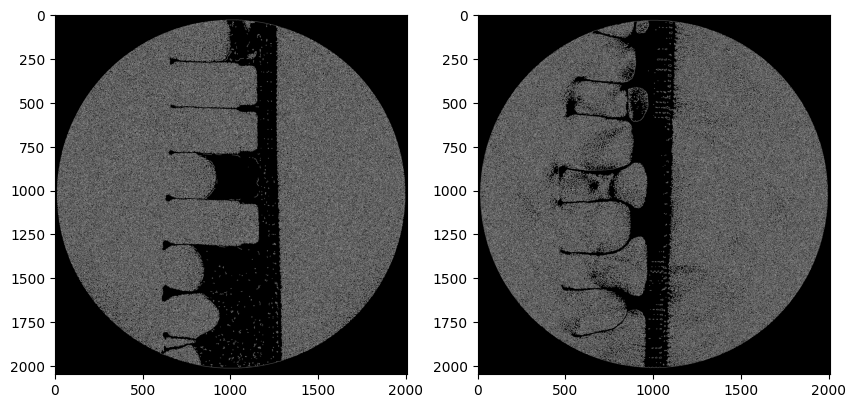

In [263]:
# Auto canny edge detector where lower and upper bounds are calculated automatically
def auto_canny(img, sigma = 0.33):
    img = normalize(img)
    blurred_img = cv2.GaussianBlur(img,(7,7),0)
    v = np.median(blurred_img)
    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    return cv2.Canny(img, lower, upper)

edges1 = auto_canny(blurred_img1)
edges2 = auto_canny(blurred_img2)
    
my_plot(1, 2, [edges1, edges2])

# Background subtraction

The idea is to learn the background of X-ray images in a dataset using the running average method. Then subtract the learnt background image from each image in the dataset to get foreground only

Note: Works on the assumption that background remains fairly static and only foreground changes

**Observations:**
* Works well in the absence of honey, as presence of honey increases pixel intensities in the background image and this causes loss of honeycomb structures when background subtraction is performed.
* Foreground image is noisy and needs morphological operations to clean the image. Foreground produced is not as clean as the histogram method.
* Honey still remains part of the foreground.

In [298]:
# Compute background using running average
def get_background(img_files, alpha = 0.005):
    avg_img = cv2.imread(img_files[0], cv2.IMREAD_GRAYSCALE)
    for img_path in img_files[1:]:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.GaussianBlur(img,(7,7),0)
        avg_img = (1 - alpha) * avg_img + (alpha) * img
        avg_img = cv2.GaussianBlur(avg_img,(7,7),0)
    
    return np.array(avg_img, dtype='uint8')

In [299]:
# Background subtraction to get foreground image
def get_foreground(img, background):
    diff = np.maximum(0, img.astype(np.int32) - background.astype(np.int32))
    img = cv2.morphologyEx(diff.astype(np.uint8), cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    ret, thresh = cv2.threshold(img, 0.5, 255, 0)
    thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 1)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)))
    
    return thresh

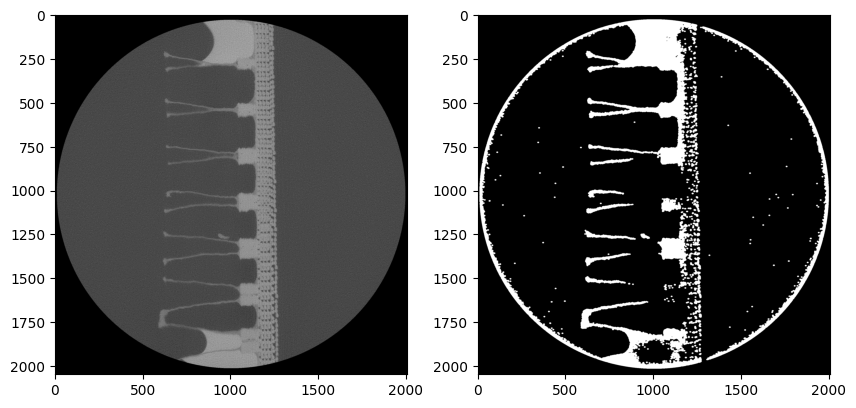

In [383]:
img = cv2.imread(sorted(tiff_dirs[list(sorted(tiff_dirs.keys()))[2]])[200], cv2.IMREAD_GRAYSCALE)
# background = get_background(sorted(tiff_dirs[list(sorted(tiff_dirs.keys()))[2]]))
diff = get_foreground(img, background)

my_plot(1, 2, [img, diff])

In [344]:
# This snippet generates videos of foreground extracted using the background subtraction for all datasets
dataset_path = '/media/chethan749/Honeycomb/combined/fixed_rec/'

tiff_dirs = get_tiff_dict(dataset_path)     
    
for tiff_dir in sorted(tiff_dirs.keys()):
    background = get_background(tiff_dirs[tiff_dir])
    bgs_solution_path = f'{tiff_dir}/bgs/'
    
    try:
        tiff_template = Image.open(f'{tiff_dir}/0001.tiff')
    except:
        continue # Solution dir
        
    if not os.path.isdir(bgs_solution_path):
        os.makedirs(bgs_solution_path)
        
    if not os.path.isdir(f'{bgs_solution_path}/tiff/'):
        os.makedirs(f'{bgs_solution_path}/tiff/')
        
    temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(bgs_solution_path + tiff_dir.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))
    
    print('Begin computing foreground of ' + tiff_dir)
    for i, file in enumerate(sorted(tiff_dirs[tiff_dir])):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        thresh = get_foreground(img, background)
        out.write(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR))
        
        tiff_image = cv2.imread(file, -1)
        tiff_masked = cv2.bitwise_and(tiff_image, (thresh > 0).astype(np.uint16) * 0xffff)
        write_tiff(tiff_template, f'{bgs_solution_path}/tiff/{i}.tiff', tiff_masked)

    print('Finish computing foreground of ' + tiff_dir)

    out.release()

Begin computing foreground of /media/chethan749/Honeycomb/combined/fixed_rec
Finish computing foreground of /media/chethan749/Honeycomb/combined/fixed_rec


## Histogram for images

This method to segment foreground honeycomb from the background worked best. The method is implemented as follows:
* Get the histogram for the image
* Remove count of black pixels as they are the highest and not relevant to our task
* After removing black pixels, the highest peak corresponds to background. Make all the pixels corresponding to this peak black, effectively removing background
* Generate a mask of the foreground generated in the previous step
* Open and dilate the mask to remove noise and make honeycomb structures clear

TODOs:
* Honey still remains part of foreground - Segment it out (Low prioirty)

In [434]:
def get_hist_fg(img):
#     norm = normalize(img)
    blurred_img = cv2.GaussianBlur(img, (7, 7), 0)

    hist = cv2.calcHist([blurred_img],[0],None,[256],[0,256])
    hist = np.squeeze(hist)
    hist[0] = 0

    peak = np.argmax(hist)
    start = peak
    for i in range(peak, 256):
        if hist[i] < 0.04 * hist[peak]:
            break
        start += 1
    
    mask = np.where(img > start, 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), 0)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)))

    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image, mask, hist

In [279]:
# This snippet generates videos of foreground extracted using histogram thresholding for all datasets
dataset_path = '/media/chethan749/Honeycomb/combined/New_sample_3x/'

tiff_dirs = get_tiff_dict(dataset_path)     
    
for tiff_dir in sorted(tiff_dirs.keys()):
    hist_solution_path = f'{tiff_dir}/hist_threshold/'
        
    try:
        tiff_template = Image.open(f'{tiff_dir}/0001.tiff')
    except:
        continue # Solution dir
        
    if not os.path.isdir(hist_solution_path):
        os.makedirs(hist_solution_path)
    
    if not os.path.isdir(f'{hist_solution_path}/tiff/'):
        os.makedirs(f'{hist_solution_path}/tiff/')
        
    temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(hist_solution_path + tiff_dir.split('/')[-1] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))
    
    print('Begin computing foreground of ' + tiff_dir)
    for i, file in enumerate(sorted(tiff_dirs[tiff_dir])):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        masked_image, thresh, hist = get_hist_fg(img)
        tiff_image = cv2.imread(file, -1)
        tiff_masked = cv2.bitwise_and(tiff_image, (thresh > 0).astype(np.uint16) * 0xffff)
        write_tiff(tiff_template, f'{hist_solution_path}/tiff/{i}.tiff', tiff_masked)
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish computing foreground of ' + tiff_dir)

    out.release()

Begin computing foreground of /media/chethan749/Honeycomb/combined/fixed_rec
Finish computing foreground of /media/chethan749/Honeycomb/combined/fixed_rec


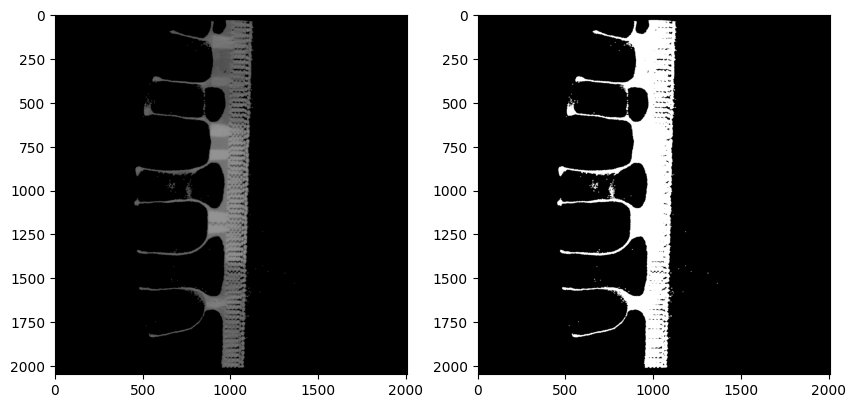

In [435]:
masked_image, thresh, hist = get_hist_fg(img2)
my_plot(1, 2, [masked_image, thresh])

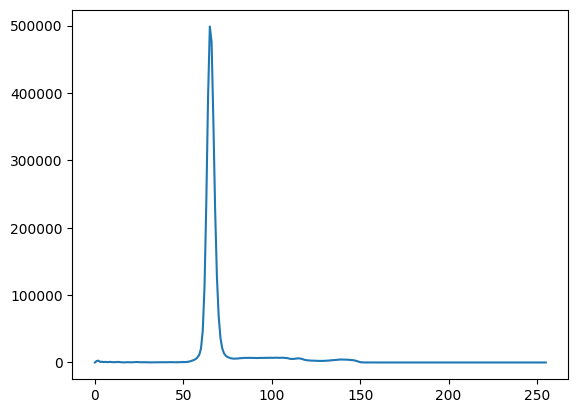

In [436]:
plt.plot(hist)
plt.show()

# Background Subtraction to remove plastic

Background subtraction is applied after histogram thresholding to generate an mask for the plastic region. The exact steps are as follows:
* Get the average image of all frames using running average.
* Since the plastic is the only static part of the image, the parts corresponding to plastic in the average image are brighter than other parts.
* Threshold out the plastic part, generate a mask and apply this mask on all frames in the dataset.

Observations:
* Plastic plate moves slightly from right to left in the dataset and therefore a static mask is not ideal.
* The mask sometimes covers the plastic edges as well for most frames.
* This suggests that it would be better to come up with a method that generates a mask individually on each frame, not one static mask for the whole data.

In [299]:
# Compute background using running average
def get_background_from_video(path, alpha = 0.005):
    cap = cv2.VideoCapture(path)
    ret, avg_img = cap.read()
    avg_img = cv2.cvtColor(avg_img, cv2.COLOR_BGR2GRAY)
    avg_img = normalize(avg_img)
    avg_img = cv2.dilate(avg_img, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), iterations = 3)
    
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        frame = normalize(frame)
        frame = cv2.dilate(frame, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), iterations = 3)
        avg_img = (1 - alpha) * avg_img + (alpha) * frame
    
    cap.release()
    
    return np.array(avg_img, dtype='uint8')

def remove_plastic(path):
    avg = get_background_from_video(path, 0.001)
    print(avg.shape)
    ret, frame = cv2.threshold(avg, 150, 255, 0)
    thresh = cv2.dilate(frame, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), iterations = 5)
    
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    rect = cv2.minAreaRect(contours[0])
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    mask_contour_rect = np.zeros(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
    cv2.drawContours(mask_contour_rect, [box], -1, (255,255,255), -1)
    
    path_split = path.split('/')
    path_split[-1] = path_split[-1].split('.')[0] + '_plastic_masked.mp4'
    output_path = '/'.join(path_split)
    
    cap = cv2.VideoCapture(path)
    ret, frame = cap.read()
    out = cv2.VideoWriter(output_path, cv2.VideoWriter_fourcc(*'mp4v'), 15, (frame.shape[1], frame.shape[0]))
    
    while cap.isOpened():
        masked_frame = cv2.bitwise_and(frame, 255 - mask_contour_rect)
        out.write(masked_frame)
        
        ret, frame = cap.read()
        
        if not ret:
            break
    
    cap.release()
    out.release()
    
    return avg

In [300]:
avg = remove_plastic('data/solution/wax_3x_zoomed_out_1_recon.mp4')

(2048, 2006)


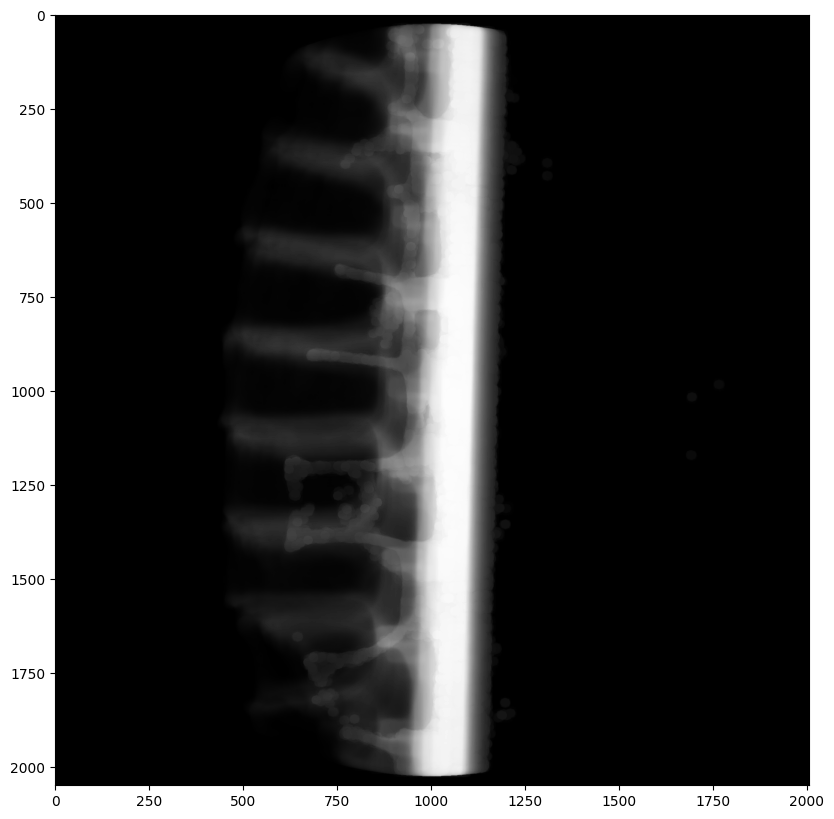

In [288]:
ret, thresh = cv2.threshold(avg, 150, 255, 0)
thresh = cv2.dilate(thresh, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(9,9)), iterations = 5)

contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
rect = cv2.minAreaRect(contours[0])
box = cv2.boxPoints(rect)
box = np.int0(box)

contour_img = np.zeros(cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR).shape, dtype='uint8')
cv2.drawContours(contour_img, [box], -1, (255,255,255), -1)

my_plot(1, 1, [avg])

(2048, 2006) (2048, 2008)


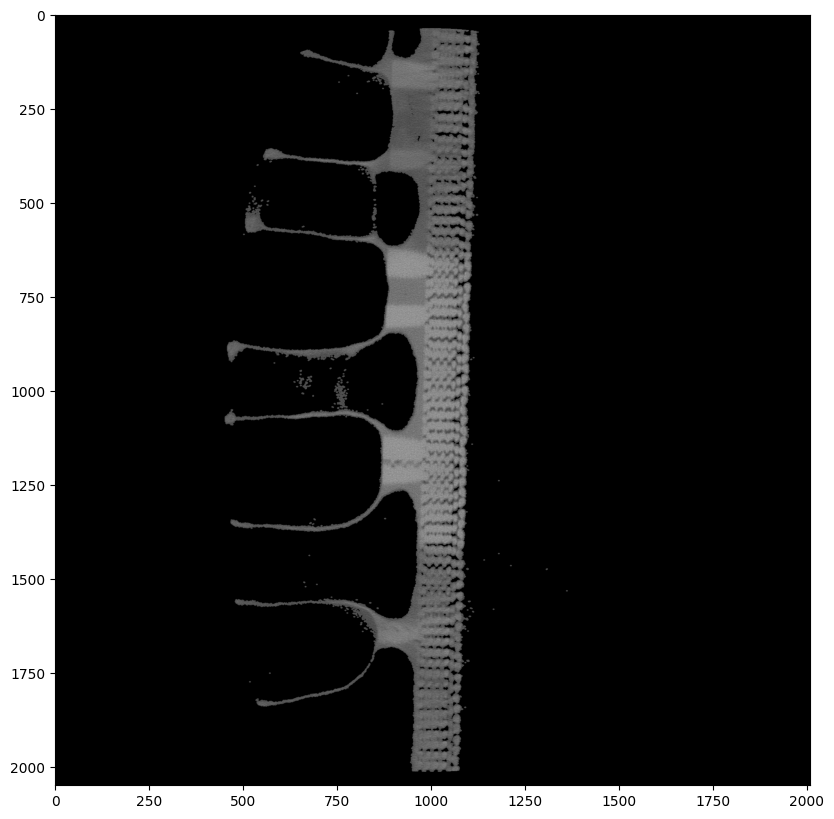

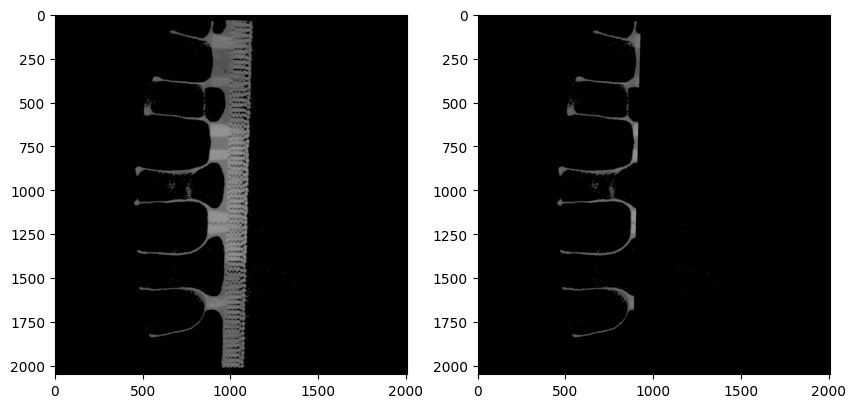

In [304]:
temp = cv2.cvtColor(contour_img, cv2.COLOR_BGR2GRAY)
temp = cv2.bitwise_and(masked_image[:, :2006], 255 - temp)
my_plot(1, 2, [masked_image, temp])

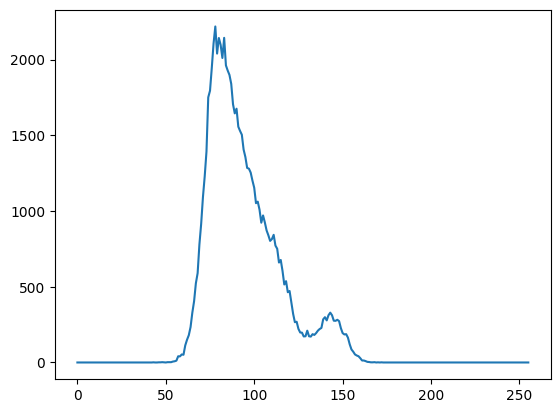

In [305]:
hist = cv2.calcHist([temp],[0],None,[256],[0,256])
hist = np.squeeze(hist)
hist[0] = 0

plt.plot(hist)
plt.show()

# Experimentation on gradient operators

Some gradient operators are applied on the histogram masked image to obtain texture/pattern descriptors from the images. Some of the operators tried are:
* Sobel/Scharr
* Prewitt

These operators provide decent texture descriptors but are not as good as LBP which is shown in the next section

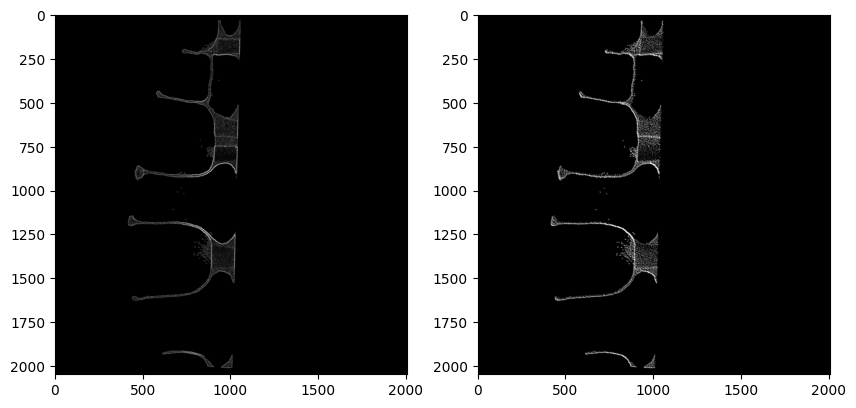

In [469]:
# Some experimentation on other gradient operators
# masked_img, thresh, hist = get_hist_fg(img2)
masked_img = img
masked_img = normalize(masked_img)
masked_img = cv2.GaussianBlur(masked_img, (7, 7), 0)

# Scharr
ksize = 3
gX = cv2.Sobel(masked_img, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=ksize)
gY = cv2.Sobel(masked_img, ddepth=cv2.CV_32F, dx=0, dy=1, ksize=ksize)
# the gradient magnitude images are now of the floating point data
# type, so we need to take care to convert them back a to unsigned
# 8-bit integer representation so other OpenCV functions can operate
# on them and visualize them
gX = cv2.convertScaleAbs(gX)
gY = cv2.convertScaleAbs(gY)
# combine the gradient representations into a single image
scharr = cv2.addWeighted(gX, 0.5, gY, 0.5, 0)

kernelx = np.array([[3,10,3],[0,0,0],[-3,-10,-3]])
kernely = np.array([[-3,0,3],[-10,0,10],[-3,0,3]])
img_prewittx = cv2.filter2D(masked_img, -1, kernelx)
img_prewitty = cv2.filter2D(masked_img, -1, kernely)
prewitt = cv2.addWeighted(img_prewittx, 0.5, img_prewitty, 0.5, 0)

my_plot(1, 2, [scharr, prewitt])

# Pattern based method

Since background subtraction for plastic removal does not give the best results, pattern matching techniques are explored. The objective is to use a standalone image, generate texture/pattern features and use those features to segment out parts of the image corresponding to plastic. These are some of the methods explored:
* Local Binary Patterns (LBP) + Linear SVM
* LBP + template matching

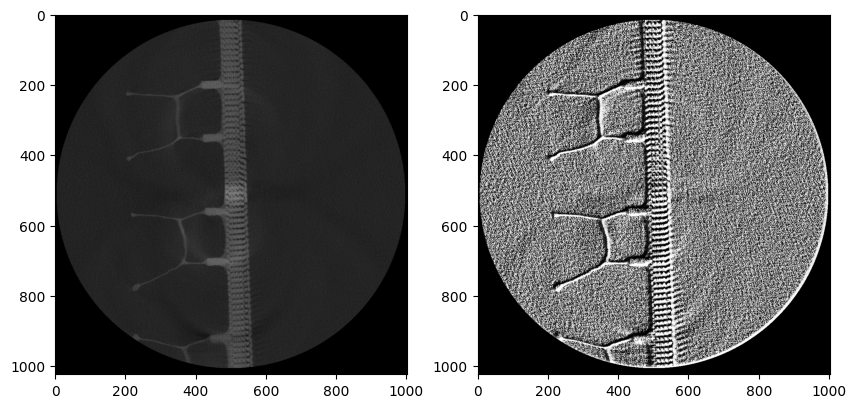

In [310]:
from skimage.feature import local_binary_pattern

lbp = local_binary_pattern(img, 16, 8)
lbp = 255 - (lbp - np.min(lbp)) / (np.max(lbp) - np.min(lbp)) * 255

my_plot(1, 2, [img, lbp])

## LBP + SVM

* Takes a long time to generate datapoints from the image.
* Takes a very long time to generate predictions for every frame (about 5-10 minutes) which is not very practical
* Segmentation results are not optimal, there are a lot of false positives for plastic. This can be fine-tuned by providing better labels and some hyperparameter tuning.

Due to the above factors, this method is not practical or accurate, hence LBP in combination with Template Matching is attempted in the next seciton which gives much better results within a short runtime

In [586]:
def get_lbp_datapoints(img):
    k = 49
    step = 1
    # desc = LocalBinaryPatterns(24, 8)
    temp = cv2.copyMakeBorder(img, k // 2, k // 2, k // 2, k // 2, cv2.BORDER_CONSTANT)
    lbp = local_binary_pattern(temp, 16, 8)
    data = np.zeros((img.shape[0], img.shape[1], 18))
    # lbp = 255 - (lbp - np.min(lbp)) / (np.max(lbp) - np.min(lbp)) * 255
    # eroded = cv2.erode(lbp, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)), iterations = 1)

    for i in range(0, lbp.shape[0] // step * step - k, step):
        row = []
        for j in range(0, lbp.shape[1] // step * step - k, step):
    #         print(i * k + k, j * k + k)
            data[i, j], _ = np.histogram(lbp[i : i + k, j : j + k].ravel(),
                bins=np.arange(0, 16 + 3),
                range=(0, 16 + 2))
    #         hist = desc.describe(masked_image[i : i + k, j : j + k])
    
    return data.reshape((data.shape[0] * data.shape[1], data.shape[2]))

In [580]:
label = cv2.imread('label.png', cv2.IMREAD_GRAYSCALE)

print(data.shape, label.shape)
X = data.reshape((data.shape[0] * data.shape[1], data.shape[2]))
y = label / 255
y = y.reshape((y.shape[0] * y.shape[1]))
print(X.shape, y.shape)

(2048, 2008, 18) (2048, 2008)
(4112384, 18) (4112384,)


In [581]:
from sklearn.svm import LinearSVC

model = LinearSVC(C=100.0, random_state=42)
model.fit(X, y)

/home/chethan749/.virtualenvs/peleg/lib/python3.8/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(C=100.0, random_state=42)

In [582]:
def video_to_frames(video, path):
    cap = cv2.VideoCapture(video)
    
    i = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        
        cv2.imwrite(path + str(i) + '.png', cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        i += 1
        
    cap.release()

# video_to_frames('data/solution/wax_3x_zoomed_in_1_recon.mp4', 'data/solution/frames/')

In [588]:
img = cv2.imread('data/solution/frames/500.png', cv2.IMREAD_GRAYSCALE)

X = get_lbp_datapoints(img)
preds = model.predict(X)

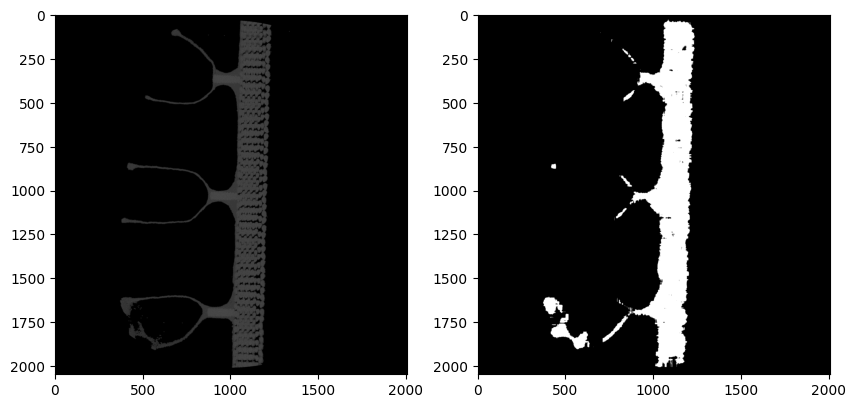

In [595]:
prediction_image = preds.reshape((img.shape[0], img.shape[1], 1))

my_plot(1, 2, [img, prediction_image * 255])

## LBP + Template Matching

The following steps are done to segment plastic regions from images:
* LBP image is generated for the slice. LBP generates pattern descriptors for each pixel in the image
* Use precomputed template images representing the pattern to be matched (plastic region in our case)
* Perform template matching to get a list of the matching points in the slice
* Dilate the matching points obtained to fill the entire plastic region (dilation iterations is a hyperparameter which needs to be adjusted between datasets)
* Obtain a bounding box for the dilated contour. This bounding box serves as the mask of plastic region in the slice.

In [370]:
def get_plastic_mask_lbp_tm(img, templates):
    k = templates[0].shape[0]
    lbp = local_binary_pattern(img, 16, 8)
    lbp = cv2.copyMakeBorder(lbp, k // 2 - 1, k // 2, k // 2 - 1, k // 2, cv2.BORDER_CONSTANT)
    lbp = 255 - (lbp - np.min(lbp)) / (np.max(lbp) - np.min(lbp)) * 255
    
    results = []
    for template in templates:
        results.append(cv2.matchTemplate(lbp.astype(np.uint8), template.astype(np.uint8), cv2.TM_CCOEFF_NORMED))

    target_points = np.zeros(results[0].shape)
    for result in results:
        target_points += result > 0.5

    dilated_result = cv2.dilate(target_points.astype(np.uint8), cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)), iterations = 11)

    contours, _ = cv2.findContours(dilated_result.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # Find the bounding box for plastic contour (which is the largest contour in the image)
    max_contour = max(contours, key = cv2.contourArea)
#     hull_list = []
#     hull = cv2.convexHull(max_contour)
#     hull_list.append(hull)
    rect = cv2.minAreaRect(max_contour)
    box = cv2.boxPoints(rect)
    box = np.int0(box)

    plastic_mask = np.zeros((result.shape[0], result.shape[1], 3))
    cv2.drawContours(plastic_mask, [box], 0, (255, 255, 255), -1)
    plastic_mask = cv2.cvtColor(plastic_mask.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    
    return target_points, plastic_mask

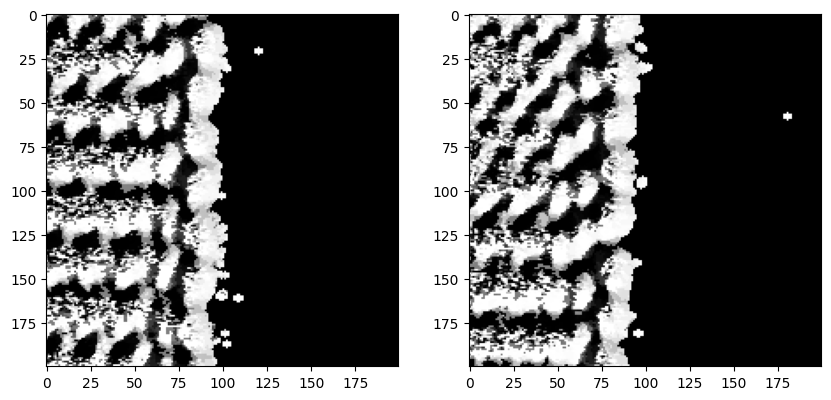

In [328]:
# Get templates of plastic region
img = cv2.imread('image.png', cv2.IMREAD_GRAYSCALE)

lbp = local_binary_pattern(img, 16, 8)
lbp = 255 - (lbp - np.min(lbp)) / (np.max(lbp) - np.min(lbp)) * 255

template1 = lbp[980: 1180, 1000: 1200]
template2 = lbp[1180: 1380, 1000: 1200]
template3 = lbp[1380: 1580, 1000: 1200]

templates = [template1, template2, template3]
my_plot(1, 2, [template1, template2])

In [371]:
# This snippet generates videos of foreground extracted using the histogram method above for all datasets
dataset_path = '/media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1'
# Zoomed in - 0.4, 15
# Zoomed out - 0.5, 11
# fixed_rec - 0.1, 2?
tiff_dirs = get_tiff_dict(dataset_path)     
    
for tiff_dir in sorted(tiff_dirs.keys()):
    lbp_tm_solution_path = f'{tiff_dir}/../../lbp_tm/'
    
    if not 'hist_threshold' in tiff_dir:
        continue
    
    try:
        tiff_template = Image.open(f'{tiff_dir}/../../0001.tiff')
    except:
        continue # Solution dir
    
    if not os.path.isdir(lbp_tm_solution_path):
        os.makedirs(lbp_tm_solution_path)
        
    if not os.path.isdir(f'{lbp_tm_solution_path}/tiff/'):
        os.makedirs(f'{lbp_tm_solution_path}/tiff/')
        
    temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(lbp_tm_solution_path + tiff_dir.split('/')[-3] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))
    
    print('Begin computing foreground of ' + tiff_dir)
    for i, file in enumerate(sorted(tiff_dirs[tiff_dir], key = lambda x: int(x.split(os.path.sep)[-1].split('.')[0]))):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        target_points, plastic_mask = get_plastic_mask_lbp_tm(img, templates)
        masked_image = cv2.bitwise_and(img, 255 - plastic_mask)
        tiff_image = cv2.imread(file, -1)
        tiff_masked = cv2.bitwise_and(tiff_image, ((255 - plastic_mask) > 0).astype(np.uint16) * 0xffff)
        write_tiff(tiff_template, f'{lbp_tm_solution_path}/tiff/{i}.tiff', tiff_masked)
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish computing foreground of ' + tiff_dir)

    out.release()

Begin computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/hist_threshold/tiff
Finish computing foreground of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/hist_threshold/tiff


(2048, 2008) (2048, 2008)


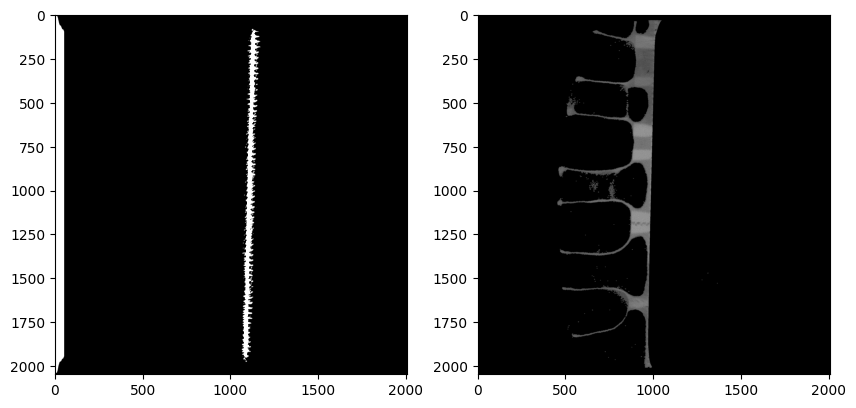

In [86]:
print(masked_image.shape, mask.shape)
my_plot(1, 2, [result * 255, cv2.bitwise_and(masked_image, 255 - mask)])

# Segment plastic

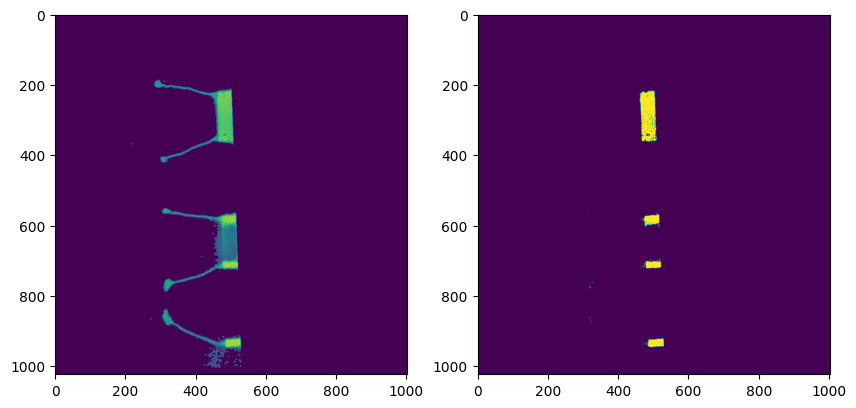

In [727]:
# img = cv2.imread('/media/chethan749/Honeycomb/combined/fixed_rec/lbp_tm/tiff/790.tiff', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('/media/chethan749/Honeycomb/combined/fixed_rec/lbp_tm/tiff/161.tiff', cv2.IMREAD_GRAYSCALE)
# Test non-gray cmap for plotting 16-bit images
# img = (img - np.min(img)) / (np.max(img) - np.min(img)) * 0xffff
# img = normalize(img)

eq_img = normalize(img)

my_plot(1, 2, [img, eq_img > 181], 'a')

253
423.0


(array([ 13,  19,  28,  32,  36,  48,  56,  60,  63,  68,  77,  79,  81,
        134, 139, 193]),)

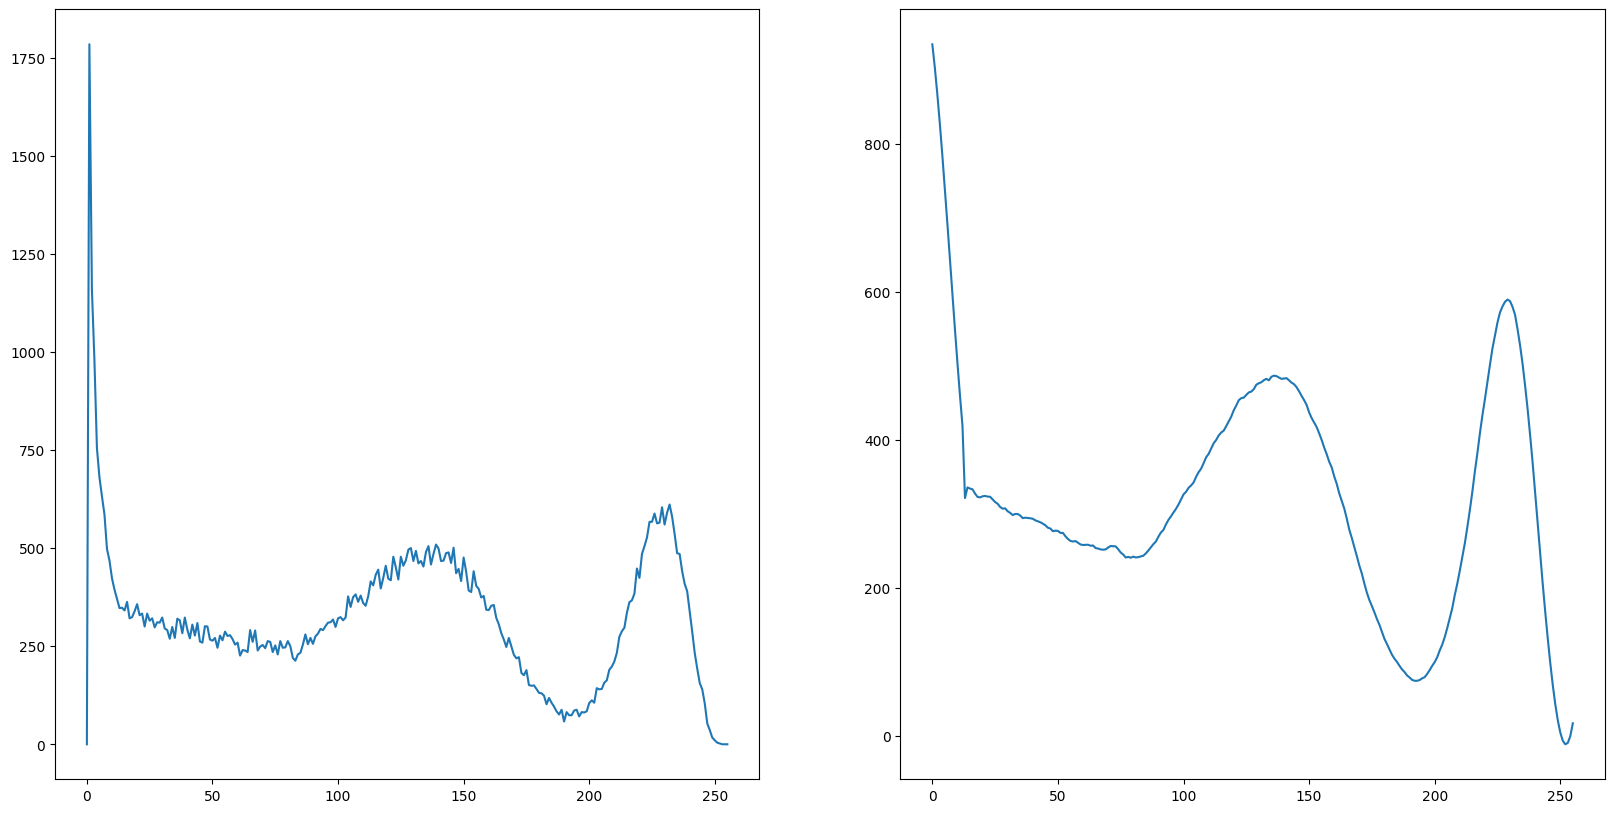

In [591]:
# from scipy import stats
from skimage.exposure import histogram
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema

# yhat = savgol_filter(y, 51, 3)

img = eq_img
img = cv2.GaussianBlur(img, (3, 3), 0)

print(np.max(img) + 1)
hist = cv2.calcHist([img],[0],None,[256],[0,256])
# hist = histogram(img)[0]
hist = np.squeeze(hist)
hist[0] = 0
# smooth = stats.gaussian_kde(img[img != 0])
# curve = smooth(np.linspace(0,256, 256))
curve = savgol_filter(hist, 25, 3)

print(hist[10])
# plt.plot(curve(np.linspace(0,256, 256)))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.plot(hist)
ax2.plot(curve)
# plt.show()
argrelextrema(curve[:-10], np.less)

In [737]:
# from scipy import stats
from skimage.exposure import histogram
from scipy.signal import savgol_filter
from scipy.signal import argrelextrema

def get_hist_plastic(img):
    norm = normalize(img)
    blurred_img = cv2.GaussianBlur(norm, (3, 3), 0)

    # hist = histogram(img)[0]
    hist = cv2.calcHist([blurred_img],[0],None,[256],[0,256])
    hist = np.squeeze(hist)
    hist[0] = 0
    
    curve = savgol_filter(hist, 51, 3)
    # smooth = stats.gaussian_kde(img[img != 0])
    # curve = smooth(np.linspace(0,256, 256))

    start = argrelextrema(curve[:-10], np.less)[0][-1]
    # Check if minimum returned is a false positive
    if curve[start] > curve[start - 10] or curve[start] > curve[start + 10 if start + 10 < 256 else 255]:
        start = argrelextrema(curve[:-10], np.less)[0][-2]
    
    mask = np.where(norm > start, 255, 0).astype(np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(3,3)))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)))
    mask = cv2.dilate(mask, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 1)
    
#     contours, hierarchy = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
#     plastic_contours = []
#     for contour in contours:
#         if cv2.contourArea(contour) > 500:
#             plastic_contours.append(contour)

#     hull_list = []
#     for contour in plastic_contours:
#         hull = cv2.convexHull(contour)
#         hull_list.append(hull)
#     mask = cv2.drawContours(np.zeros(mask.shape), hull_list, -1, (255, 255, 255), -1)
            
    masked_image = img
    masked_image[mask == 255] = 255
    
    return masked_image, mask, curve

In [739]:
# This snippet generates videos of plastic segmentation using the histogram method above for all datasets
dataset_path = '/media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1'
tiff_dirs = get_tiff_dict(dataset_path)
    
for tiff_dir in sorted(tiff_dirs.keys()):
    if not 'lbp_tm' in tiff_dir:
        continue
    
    try:
        tiff_template = Image.open(f'{tiff_dir}/../../0001.tiff')
    except:
        continue # Solution dir
        
    plastic_segment_solution_path = f'{tiff_dir}/../../plastic_segmented/'
    
    if not os.path.isdir(plastic_segment_solution_path):
        os.makedirs(plastic_segment_solution_path)
        
    if not os.path.isdir(f'{plastic_segment_solution_path}/tiff/'):
        os.makedirs(f'{plastic_segment_solution_path}/tiff/')
        
    temp_img = cv2.imread(tiff_dirs[tiff_dir][0], cv2.IMREAD_GRAYSCALE)
    out = cv2.VideoWriter(plastic_segment_solution_path + tiff_dir.split('/')[-3] + '.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 15, (temp_img.shape[1], temp_img.shape[0]))
    
    print('Begin plastic segmentation of ' + tiff_dir)
    for i, file in enumerate(sorted(tiff_dirs[tiff_dir], key = lambda x: int(x.split(os.path.sep)[-1].split('.')[0]))):
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        masked_image, plastic_mask, hist = get_hist_plastic(img)
        tiff_image = cv2.imread(file, -1)
        tiff_masked = tiff_image
        tiff_masked[plastic_mask == 255] = 0xffff
        write_tiff(tiff_template, f'{plastic_segment_solution_path}/tiff/{i}.tiff', tiff_masked)
        out.write(cv2.cvtColor(masked_image, cv2.COLOR_GRAY2BGR))
    print('Finish plastic segmentation of ' + tiff_dir)

    out.release()

Begin plastic segmentation of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/lbp_tm/tiff
Finish plastic segmentation of /media/chethan749/Honeycomb/combined/New_sample_3x/zoomed_out_1/wax_3x_zoomed_out_1_recon/lbp_tm/tiff


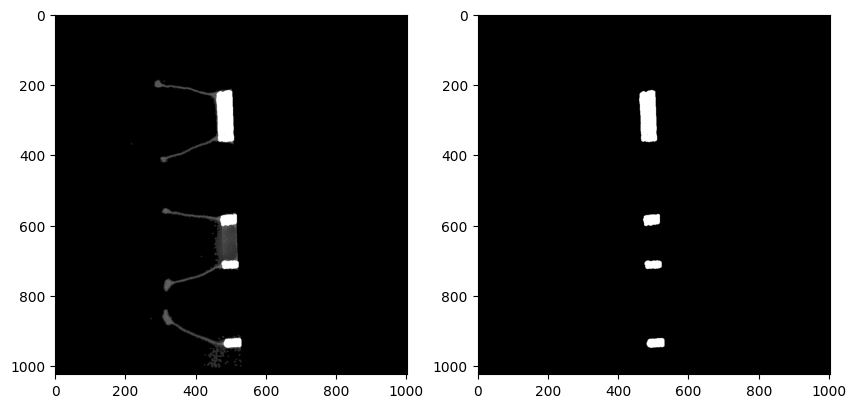

In [733]:
img = cv2.imread('/media/chethan749/Honeycomb/combined/fixed_rec/lbp_tm/tiff/161.tiff', cv2.IMREAD_GRAYSCALE)
masked_image, mask, hist = get_hist_plastic(img)

my_plot(1, 2, [masked_image, mask])

In [731]:
hist[229] - hist[189]

30.028465

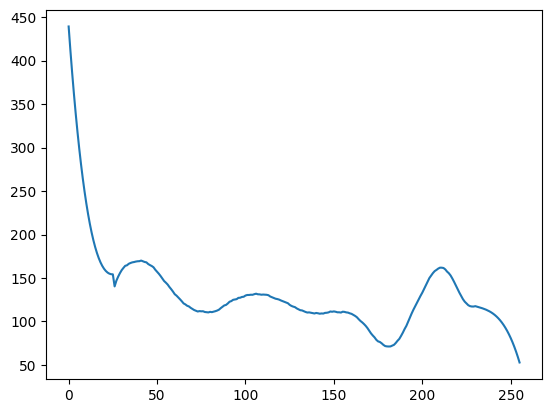

array([ 26,  73,  75,  79,  81, 104, 109, 135, 139, 142, 144, 149, 154,
       181, 229])

In [726]:
plt.plot(hist)
plt.show()
argrelextrema(hist[:-10], np.less)[0]

# Superpixel segmentation

Experimentation only. Can this be used to remove honey? (Not a priority currently)

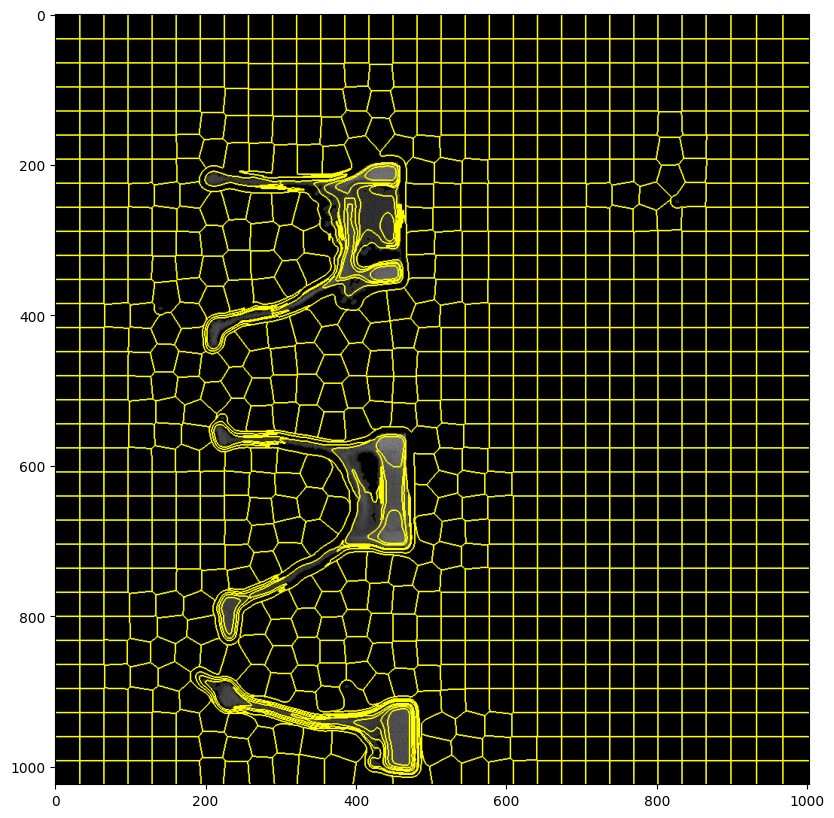

In [66]:
from skimage.segmentation import slic, mark_boundaries
from skimage.util import img_as_float

# masked_img, thresh, hist = get_hist_fg(img2)
segments = slic(img_as_float(img), compactness = 0.01, n_segments = 1000, sigma = 5)

# show the plots
my_plot(1, 1, [mark_boundaries(img, segments)])

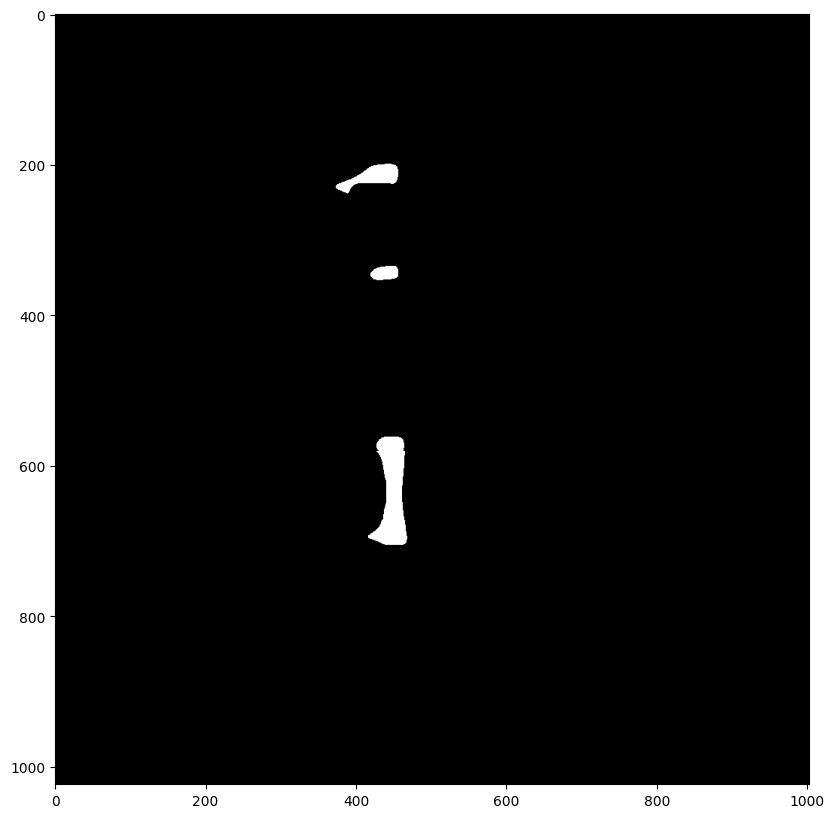

In [68]:
mean_segments = np.zeros(img.shape)
for i in range(np.max(segments)):
    mean_segments[segments == (i + 1)] = np.sum(img[segments == (i + 1)]) / np.sum(segments == (i + 1))

my_plot(1, 1, [(mean_segments > 80) * 255])